In [1]:
import numpy as np
import numpy.linalg
import scipy.stats
from scipy.signal import argrelextrema
import pandas as pd

import argparse
import textwrap

import emcee
import george
# for parallel tempering
from emcee import PTSampler

from emcee_utils import walker_params
from plotting import plot_lightcurve, plot_folded_lightcurve, plot_mcmc_sampling_results, plot_steps
import matplotlib.pyplot as plt

In [2]:
def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    param[0] : float
        mean (between 0 and 2)

    param[1] : float
        log amplitude (between -10 and 10)

    param[2] : float
        gamma (log gamma between 0.1 and 40)

    param[3] : float
        log period (period between 1h and 24hrs)

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    #p_mean = scipy.stats.uniform(0,20).logpdf(params[0])
    p_mean = scipy.stats.norm(1, 0.5).logpdf(params[0])
    p_log_amp = scipy.stats.uniform(-10,30).logpdf(params[1])
    #p_log_gamma = scipy.stats.uniform(np.log(0.1), (np.log(40)-np.log(0.1))).logpdf(np.log(params[2]))
    p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    ###print this line to get the prob value: p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    p_period = scipy.stats.uniform(np.log(1./24.), -np.log(1./24.)).logpdf((params[3]))

    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior


def logl(params, gp, tsample, fsample, flux_err):
     # compute lnlikelihood based on given parameters
     gp.set_parameter_vector(params)


     try:
         gp.compute(tsample, flux_err)
         lnlike = gp.lnlikelihood(fsample)
     except np.linalg.LinAlgError:
         lnlike = -1e25

     return lnlike


def post_lnlikelihood(params, gp, tsample, fsample, flux_err):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """

    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    try:
        lnlike = logl(params, gp, tsample, fsample, flux_err)
        ln_likelihood = lnlike+log_prior

    except np.linalg.linalg.LinAlgError:
        ln_likelihood = -1e25

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25


def read_data(filename, datadir="./"):
    """
    Read in light curve data from asteroid.
    """

    data  = pd.read_csv(datadir+filename, header=None, delim_whitespace=False)

    tsample = data[0]
    fsample = data[1]
    flux_err = data[2]
    data_pts = len(tsample)

    return tsample, fsample, flux_err, data_pts


In [3]:
# set up
filename = "221_lc_49627_to_49787.txt_sampled_semi-dense_60days_equal_dist"
datadir="../data/"
nchain=100
niter=100
gamma=1
cov_scale=1
threads=1

In [4]:
#read in the data
tsample, fsample, flux_err, data_pts = read_data(filename, datadir)

#get l-s best period estimate
from lombscargle import make_lsp
from astropy.stats import LombScargle

freq, power = make_lsp(tsample, fsample, flux_err, p_max=5.0)

# determine the indices of local power maxima
best_idx = argrelextrema(power, np.greater)

# sort these indices based on actual power value
# reverse list so max is read first
indices = np.argsort(power[best_idx[0]])[::-1]

# sort our original indices based on the new
# power-sorted indices
best_idx = (best_idx[0]).T[indices]
best_freqs = freq[best_idx].T

new_freq = best_freqs[0]
new_period = 1./new_freq
new_log_period = np.log(1./new_freq)

/home/christina/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


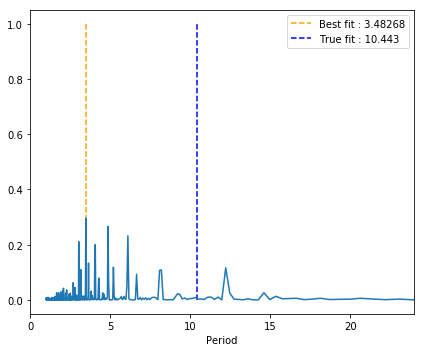

In [5]:
###change for examples
#####delete for final product
true_period = 10.443#(221) #3.603957#(3200)

fig, ax = plt.subplots(1,1, figsize=(6,5))
fig.set_tight_layout('tight')
ax.plot((1./freq)*24.,power)
ax.set_xlabel('Period')
ax.vlines(new_period*24., 0, 1, colors='orange', linestyles='--',
          label = 'Best fit : ' + str(round(new_period*24., 5)))
ax.vlines(true_period, 0, 1, colors='blue', linestyles='--',
          label = 'True fit : ' + str(true_period))
ax.set_xlim([0,24])
ax.legend()
namestr=filename + "_plots"
plt.savefig(namestr + "_lsp.pdf", format="pdf")
#####

In [10]:
ndim = 4
nwalkers = nchain
# for parallel tempering
ntemps = 20

# initialize walker parameters
gp_mean = np.mean(fsample)
log_amp = np.log(fsample.max()-fsample.min())
gamma = 1
log_period = new_log_period

params = [np.mean(fsample), log_amp, gamma, log_period]

# set up gp kernel
kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
gp = george.GP(kernel, fit_mean=True, mean=gp_mean)
gp.compute(fsample, flux_err)

# equally distributed starting period values
p_start = np.array(params)/100.
cov_matrix = np.sqrt(np.diag(p_start)**2)
p0 = np.random.multivariate_normal(mean=params, cov=cov_matrix, size=(ntemps, nwalkers))
x = np.log(np.linspace(2,12,nwalkers)/24.)
for i in range(ntemps):
    p0[i,:,3] = x


In [11]:
#sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[gp, tsample, fsample, flux_err], threads=threads)
sampler = PTSampler(ntemps=ntemps, nwalkers=nwalkers, dim=ndim, logl=logl,
                    logp=prior, loglargs=[gp, tsample, fsample, flux_err])

mcmc_sampling = sampler.run_mcmc(p0, niter)

/home/christina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log


[ 0.97578188 -2.42022189  1.05010276 -0.23682028]
[ 1.27393979 -2.51160114  1.00469289 -1.72151463]
[ 0.453611   -1.10296827  1.29917635 -0.04355886]
[ 0.85626773 -2.14841219  0.72457196 -0.90251142]
[ 1.14482946 -2.12453434  1.3282346  -0.32148979]
[ 1.49810386 15.03050746  2.99563209 -0.41522215]


/home/christina/anaconda3/lib/python3.7/site-packages/george/utils.py:30: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


[ 0.91355191 -0.09233554  2.51771163 -0.49567411]
[ 1.1385246  -0.9535717   2.90565769 -0.96800731]
[ 0.59349171 -1.56361517  0.67957241 -2.94674555]
[ 1.28915371 -2.24463859  1.5431884  -0.67419548]
100.0


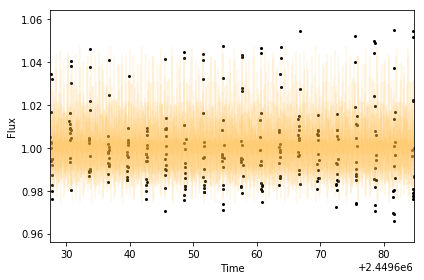

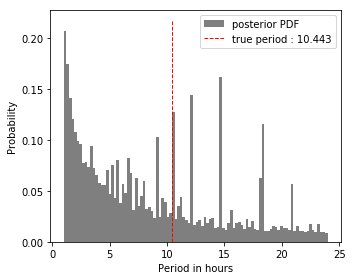

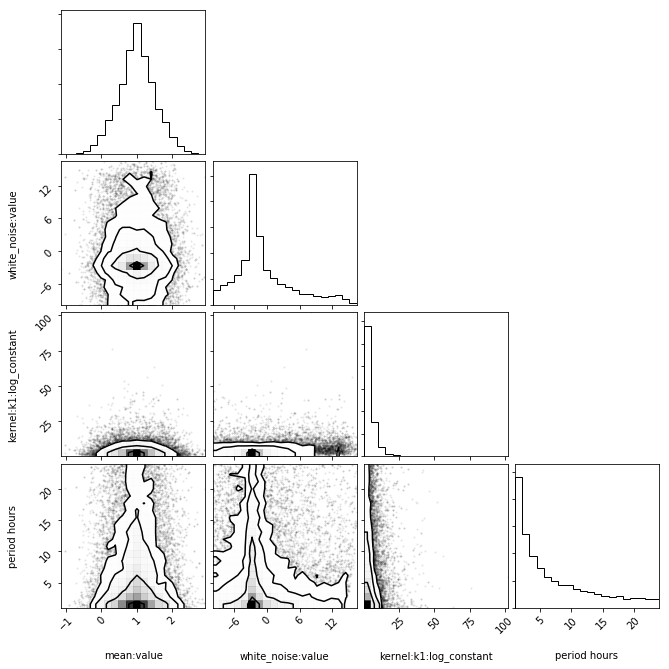

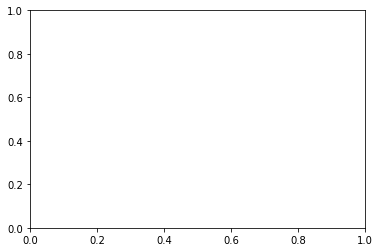

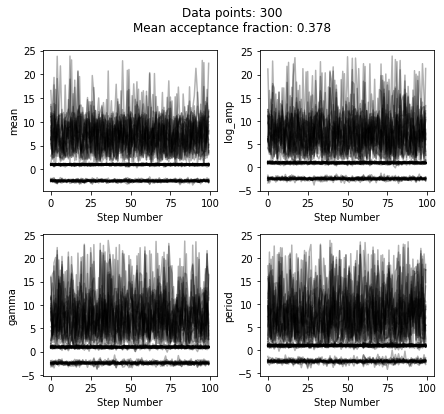

In [14]:
assert sampler.chain.shape == (ntemps, nwalkers, niter, ndim)
results = sampler.chain.reshape(ntemps*nwalkers*niter,ndim)

def save_chain(file_name, sampler, results):
    header = str(sampler.chain.shape)
    np.savetxt(file_name, results, header=header)
    return

save_chain(filename + "_results.txt", sampler, results)

###AVOID HAVING TO USE pd SO YOU DON'T HAVE TO CHANGE THIS TO A NP.ARRAY
tsample = np.array(tsample)

plot_mcmc_sampling_results(tsample, fsample, flux_err, gp, sampler, namestr=filename + "_plots", true_period=true_period)


In [13]:
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
plt.switch_backend('agg')

import numpy as np

from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import corner

from lombscargle import make_lsp

def plot_lightcurve(time, flux, flux_err=None, true_lightcurve=None,
                    models=None, ax=None, colours=None):

    """
    Plot a light curve, potentially including the true underlying
    model that produced the data (in the case of simulations), or model
    light curves from MCMC.

    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve

    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps

    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data.

    true_lightcurve : iterable containing (true_time, true_flux)
        In the case of simulated data, this contains the times and flux values from which the
        simulated data was created (could be higher-resolution than the "data"), useful for
        comparison between models created e.g. from MCMC samples and the true underlying process

    models : iterable of shape (model_time, numpy.ndarray of shape (nsamples, len(model_time)))
        First element here contains the time stamps for the models (which may not be the same
        as for the data), the second is an array of shape (nsamples, ndatapoints), where nsamples
        is the number of model light curves, and ndatapoints == len(model_time)

    ax : matplotlib.Axes object
        An Axes object in which to plot the results. If not given, the code will create a
        new figure.

    legend : bool, default True
        If True, include a legend in the plot

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.

    Returns
    -------

    ax : matplotlib.Axes object
        The object with the plot

    """

    if colours is None:
        colours = ["black", "#33B3FF", "#FFB733"]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    if flux_err is None:
        ax.scatter(time, flux, s=4, c=colours[0], marker="o")
    else:
        ax.errorbar(time, flux, yerr=flux_err, fmt="o", markersize=4, c=colours[0])

    min_time = np.min(time)
    max_time = np.max(time)

    if true_lightcurve is not None:
        true_time = true_lightcurve[0]
        true_flux = true_lightcurve[1]

        ax.plot(true_time, true_flux, lw=2, alpha=0.5, color=colours[1])

        min_time = np.min([min_time, np.min(true_time)])
        max_time = np.max([max_time, np.max(true_time)])


    if models is not None:
        m_time = models[0]
        m_flux = models[1]

        for m in m_flux:
            ax.plot(m_time, m, color=colours[2], alpha=0.1)

        min_time = np.min([min_time, np.min(m_time)])
        max_time = np.max([max_time, np.max(m_time)])

    ax.set_xlim(min_time, max_time)
    ax.set_xlabel("Time")
    ax.set_ylabel("Flux");

    return ax

def plot_lsp(time, flux, flux_err=None, true_period=None,
             p_min=1/24.0, p_max=1.0, oversampling=5, lsp_kwargs={},
             ax=None, nharmonics=0, legend=True, use_gatspy=False, nterms=1):

    """
    Plot a Lomb-Scargle periodogram of the data in (time, flux) and optionally
    include the "true" period, if known.

    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the time series **IN DAYS**

    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps

    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data.

    true_period : float
        For simulated data, we might know the true period from
        which the data came. If so, this will plot a dashed line
        where the true period should be in the Lomb-Scargle periodogram

    p_min, p_max : float, float
        The minimum and maximum period to search, **IN DAYS**

    oversampling : int
        The oversampling factor; default is 5

    lsp_kwargs : dict
        Optional keyword arguments for astropy.stats.LombScargle

    ax : matplotlib.Axes object
        A matplotlib.Axes object into which to plot the LSP. Useful
        for including an LSP in a multi-panel figure. If not given,
        this function will instantiate a new Figure.

    nharmonics : int, default 0
        The number of harmonics to plot apart from the true period.
        Plotting harmonics can be useful if there's significant power
        e.g. at 1/2 the actual period

    legend : bool, default True
        If true, include a legend


    """

    freq, power = make_lsp(time, flux, flux_err, p_min, p_max, oversampling, use_gatspy=use_gatspy,
                           nterms=nterms)

    # array of corresponding periods
    periods = 1./freq

    # invert the arrays so that my plot goes from
    # small periods --> large periods
    periods = periods[::-1]
    power = power[::-1]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    # plot the Lomb-Scargle periodogram
    ax.semilogx(periods, power, lw=2, color="black", linestyle="steps-mid", alpha=0.7, label="data")

    ylim = ax.get_ylim()

    ax.vlines(true_period, ylim[0], ylim[1], color="purple", linestyle="dashed", lw=3,
              label="true period")

    if nharmonics > 0:
        colours = sns.color_palette("viridis", n_colors=nharmonics)
        for n in range(nharmonics):
            true_period /= 2.0
            ax.vlines(true_period, ylim[0], ylim[1], color=colours[n],
                      linestyle="dashed", lw=3, label="%.2f * true period"%(0.5/(n+1)))

    if legend:
        ax.legend()

    ax.set_xlim(np.min(periods), np.max(periods))

    ax.set_xlabel("Period [days]")
    ax.set_ylabel("Normalized Power")

    return ax



def plot_folded_lightcurve(time, flux, period, flux_err=None, models=None, true_lightcurve=None,
                      ax=None, use_radians=False, legend=True, colours=None):
    """
    Plot a folded periodic light curve, potentially including the true underlying
    model that produced the data (in the case of simulations), or model
    light curves from MCMC.

    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve

    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps

    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data.

    period : float
        The period on which to fold **in hours**

    models : iterable of shape (model_time, numpy.ndarray of shape (nsamples, len(model_time)))
        First element here contains the time stamps for the models (which may not be the same
        as for the data), the second is an array of shape (nsamples, ndatapoints), where nsamples
        is the number of model light curves, and ndatapoints == len(model_time)

    true_lightcurve : iterable containing (true_time, true_flux)
        In the case of simulated data, this contains the times and flux values from which the
        simulated data was created (could be higher-resolution than the "data"), useful for
        comparison between models created e.g. from MCMC samples and the true underlying process


    ax : matplotlib.Axes object
        An Axes object in which to plot the results. If not given, the code will create a
        new figure.

    use_radians : bool, default False
        If True, the phase will be plotted from (0, 2pi) instead of (0,1), which is the default.

    legend : bool, default True
        If True, include a legend in the plot

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.

    Returns
    -------

    ax : matplotlib.Axes object
        The object with the plot

    """

    if colours is None:
        colours = ["black", "#33B3FF", "#FFB733"]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))

    t0 = np.min(time)
    if models:
        t0 = np.min([t0, np.min(models[0])])

    if true_lightcurve:
        t0 = np.min([t0, np.min(true_lightcurve[0])])

    phase = (time-t0)/period - np.floor((time-t0)/period)

    if use_radians:
        phase *= 2.*np.pi

    if flux_err is None:
        ax.scatter(phase, flux, s=5, color=colours[0], label="data")
    else:
        ax.errorbar(phase, flux, yerr=flux_err, fmt="o", c=colours[0], markersize=5, label="data")

    if true_lightcurve:
        true_time = (true_lightcurve[0] - t0)
        true_flux = true_lightcurve[1]
        true_phase = true_time/period - np.floor(true_time/period)

        if use_radians:
            true_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(true_phase)
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]

        # loop through indices where phase goes from 1 (or 2pi) to 0
        # plot each phase light curve separately
        istart = 0
        iend = idx[0]+1

        # first phase cycle also contains the label for the legend
        ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3,
                c=colours[1], label="true light curve")

        for i, x in enumerate(idx[:-1]):
            ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3, c=colours[1])
            istart = x+1
            iend = idx[i+1]+1

        # last plot
        istart = idx[-1]+1
        ax.plot(true_phase[istart:], true_flux[istart:], alpha=0.3, c=colours[1])

    if models:
        m_time = (models[0] - t0)
        m_flux = models[1]

        m_phase = (m_time/period) - np.floor(m_time/period)
        if use_radians:
            m_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(m_phase)
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]


        # loop through the different samples
        for i,m in enumerate(m_flux):
            # loop through indices where phase goes from 1 (or 2pi) to 0
            # plot each phase light curve separately
            istart = 0
            iend = idx[0]+1

            if i == 0:
                # first phase cycle also contains the label for the legend
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2], label="model")

            else:
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2])

            for j, x in enumerate(idx[:-1]):
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1, c=colours[2])
                istart = x+1
                iend = idx[j+1]+1

            # last plot
            istart = idx[-1]+1
            ax.plot(m_phase[istart:], m[istart:], alpha=0.1, c=colours[2])

    if legend:
        ax.legend()
    ax.set_xlabel("Rotational Phase")
    ax.set_ylabel("Plot")
    period_hours = period*24.
    ax.set_title(r"period $P = %.3f$"%period_hours)
    if use_radians:
        ax.set_xlim(0, 2*np.pi)
    else:
        ax.set_xlim(0, 1)
    return ax

def plot_steps(sampler, dims=None, p0=None, data_pts=None):
    fig, ax = plt.subplots(2, 2, figsize=(7,6))
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    fig.suptitle("Data points: " + str(data_pts) + "\nMean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))




    axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    iterations = results.shape[0]/(sampler.ntemps*sampler.nwalkers)
    print(iterations)
    x = np.arange(iterations)

    for i in range(sampler.dim):
        axs[i].set_xlabel('Step Number')
        axs[i].set_ylabel('{}'.format(dims[i]))

        for j in range(len(sampler.chain)):
            param = sampler.chain[j,:,i]
            axs[i].plot(x, param, 'k-', alpha=0.3)
            # fit might guess period is time range of sampling

        flatchain = sampler.flatchain[:,i]


    return axs


def plot_mcmc_sampling_results(tsample, fsample, flux_err, gp, sampler,
                          t_pred=None, true_lightcurve=None,
                          true_period=None, namestr="test",
                          nmodels=10, npred=1000):

    results = sampler.chain.reshape(ntemps*nwalkers*niter,ndim)

    # resample from weights
    new_samples = results

    # plot some light curves with example models

    # first, get the total number of available samples
    nsamples = new_samples.shape[0]

    # get some random samples from the
    idx = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nmodels)

    # if the array for the predictions isn't given, make one
    if t_pred is None:
        t_pred = np.linspace(tsample[0], tsample[-1], npred)

    # empty array for output
    m_all = np.zeros((nmodels, t_pred.shape[0]))

    # loop through the indices of samples, for each sample from the GP
    # conditional on the data points
    for i,j in enumerate(idx):
        p = new_samples[j]
        print(p)
        pnew = [p[0], p[1], p[2], p[3]]

        gp.set_parameter_vector(pnew)
        mean_model = gp.sample_conditional(fsample, t_pred)
        m_all[i] = mean_model

    fig, ax = plt.subplots(1, 1, figsize=(6,4))

    plot_lightcurve(tsample, fsample, true_lightcurve=true_lightcurve,
                        models=(t_pred, m_all), ax=ax)

    plt.tight_layout()
    plt.savefig(namestr + "_lc.pdf", format="pdf")

    # plot histogram of periods
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    ax.hist(np.exp(new_samples[:,-1])*24, bins=100, density=True,
                label="posterior PDF", color="black", alpha=0.5)

    if true_period is not None:
        ylim = ax.get_ylim()
        ax.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="true period : " + str(true_period))

    ax.set_xlabel("Period in hours")
    ax.set_ylabel("Probability")
    ax.legend()

    plt.tight_layout()
    plt.savefig(namestr + "_period_pdf.pdf", format="pdf")

    # plot folded light curve

    #fig, ax = plt.subplots(1, 1, figsize=(6,4))


    #if true_period:
    #    ax = plot_tcurve(tsample, fsample, true_period/24, flux_err=0.01,
    #                      models=[t_pred, m_all[:2]],
    #                      true_lightcurve=true_lightcurve, ax=ax, use_radians=False)
    #else:
    #    ax = plot_tcurve(tsample, fsample, best_period, flux_err=flux_err,
    #                      models=[t_pred, m_all[:2]],
    #                      true_lightcurve=true_lightcurve, ax=bx, use_radians=False)

    #plt.tight_layout()
    #plt.savefig(namestr + "_folded_lc.pdf", format="pdf")


    #convert period values from log days to hours
    x = (np.exp(new_samples.T[3])*24.)
    new_samples.T[3] = x

    labels = list(gp.parameter_names)
    labels[3] = 'period hours'

    # make a corner plot
    corner.corner(new_samples[int(-len(new_samples)*0.1):], labels=labels)

    # save to file
    plt.savefig(namestr + "_corner.pdf", format="pdf")

    #plot trace plot
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    ax = plot_steps(sampler, dims = ['mean', 'log_amp', 'gamma', 'period'], data_pts=len(fsample))
    plt.savefig(namestr + "_trace.pdf", format="pdf")
